In [1]:
from __future__ import print_function, division

import os

import numpy as np
import torch
from torch import nn, optim
from torchvision import datasets, models, transforms, utils
from torch_lr_finder import LRFinder

from matplotlib import pyplot as plt, cycler, ticker

In [6]:
BATCH_SIZE = 8
CLASSES = 2
DATA_ROOT = '../data/test/'

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.1220, 0.1220, 0.1220], [0.2058, 0.2058, 0.2058])
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.1220, 0.1220, 0.1220], [0.2058, 0.2058, 0.2058])
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.1220, 0.1220, 0.1220], [0.2058, 0.2058, 0.2058])
    ]),
}

In [7]:
image_datasets = {x: datasets.ImageFolder(os.path.join(DATA_ROOT, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
data_loaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                               batch_size=BATCH_SIZE,
                                               shuffle=True, 
                                               num_workers=4)
               for x in ['train', 'val', 'test']}

In [8]:
m_resnet50 = models.resnet50(pretrained=True)
for param in m_resnet50.parameters():
    param.requires_grad = False
    
num_ftrs = m_resnet50.fc.in_features
m_resnet50.fc = nn.Sequential(
    nn.Linear(in_features=num_ftrs, out_features=CLASSES),
    nn.Softmax(dim=1)
)

m_resnet50 = m_resnet50.to(device)

In [9]:
losses = []
lrs = []
labels = []

In [10]:
model = m_resnet50
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-9)

lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(data_loaders['train'], val_loader=data_loaders['val'], end_lr=10, num_iter=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()


In [11]:
history = lr_finder.history
losses.append(history['loss'].copy())
lrs.append(history['lr'].copy())
labels.append("SGD")

SGD LR suggestion: steepest gradient
Suggested LR: 3.76E-02


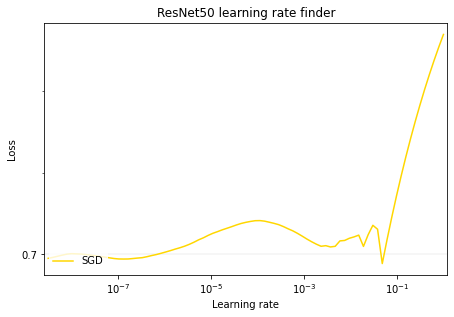

In [15]:
plots(losses, lrs, labels, title="ResNet50")

In [13]:
PLOT_SIZE_X = 7
PLOT_SIZE_Y = 5
PLOT_LEFT_POS = 0.1
PLOT_RIGHT_POS = 0.9
PLOT_BOTTOM_POS = 0.15
PLOT_TOP_POS = 0.85
PLOT_MARGIN = 0.01
PLOT_LW = 1
PLOT_GRID_LW = 0.2
PLOT_TICKS_Y_INTERVAL = 0.1

In [14]:
def plots(lss, l_rs, lbls,
          skip_start=5,
          skip_end=10,
          log_lr=True,
          show_lr=None,
          ax=None,
          suggest_lr=True, title=None
         ):
    
    colors = cycler('color', ['gold', 
                              'darkorange',
#                               'y', 
#                               'forestgreen',
#                               'turquoise', 
                              'dodgerblue',
                              'rebeccapurple'])
    plt.rc('axes', prop_cycle=colors)
    
    fig, ax = plt.subplots(figsize=(7, 5))
    plt.subplots_adjust(left=PLOT_LEFT_POS, right=PLOT_RIGHT_POS, bottom=PLOT_BOTTOM_POS, top=PLOT_TOP_POS)
    plt.margins(x=PLOT_MARGIN)

    lrs = history["lr"]
    losses = history["loss"]
    

    for ls, l_r, lbl in zip(lss, l_rs, lbls):
        if skip_end == 0:
            l_r = l_r[skip_start:]
            ls = ls[skip_start:]
        else:
            l_r = l_r[skip_start:-skip_end]
            ls = ls[skip_start:-skip_end]


        plt.plot(l_r, ls, label=lbl)

        if suggest_lr:
            print(f"{lbl} LR suggestion: steepest gradient")
            min_grad_idx = None
            try:
                min_grad_idx = (np.gradient(np.array(ls))).argmin()
            except ValueError:
                print(
                    "Failed to compute the gradients, there might not be enough points."
                )
            if min_grad_idx is not None:
                print("Suggested LR: {:.2E}".format(l_r[min_grad_idx]))

    plt.xscale("log")
    
    plt.title(f"{title} learning rate finder")
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

    legend = plt.legend(loc='lower left')
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_edgecolor('white')

    plt.grid(axis='y', lw=PLOT_GRID_LW)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1 / 5))

    plt.show()